In [146]:
import os
import sys
import igl
import torch
import trimesh
import subprocess
import numpy as np 
import pandas as pd
import open3d as o3d
import shapeworks as sw
import meshplot as mp
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm
from scipy.stats import pearsonr
from ipywidgets import interact, widgets
from sklearn.decomposition import PCA, KernelPCA
from sklearn.linear_model import LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

sys.path.append('../../utils/')
from sap_score import sap
from spca import SPCA

In [108]:
conditional = False

if conditional:
    labels = torch.load("labels.pt")
    df = pd.DataFrame(labels).transpose()
    subjects = df.index.to_list()
    volumes = df.Volume.to_numpy()
    ages = df.Age.to_numpy()
else:
    df = pd.read_csv("demographics.csv", delimiter=";")
    subjects = df.subject.to_list()
    ages = df.age.to_numpy()

In [142]:
from sklearn.utils.validation import check_is_fitted
from sklearn.utils import check_array, check_X_y

def inverse_transform(lda, x):
    if lda.solver == 'lsqr':
        raise NotImplementedError("(inverse) transform not implemented for 'lsqr' "
                                  "solver (use 'svd' or 'eigen').")
    check_is_fitted(lda, ['xbar_', 'scalings_'], all_or_any=any)

    inv = np.linalg.pinv(lda.scalings_)[:16]

    x = check_array(x)
    if lda.solver == 'svd':
        x_back = np.dot(x, inv) + lda.xbar_
    elif lda.solver == 'eigen':
        x_back = np.dot(x, inv)

    return x_back

In [110]:
# df = pd.read_csv("demographics.csv", delimiter=";")

# files = glob("data/*.nii")

# filenames = []
# for filename in files:
#     filename = filename.split("\\")[-1].replace("_standard.nii", "")
#     filenames.append(filename)
    
# for filename in filenames:
#     if not filename in df.subject.to_list():
#         print(f"There is no label for: {filename}")

# df[df.subject == "ab300_257"]

## Left hippocampus meshes

In [34]:
mesh_list = []

for mesh_path in tqdm(sorted(glob("groomed/*left.vtk"))):
    subject_name = mesh_path.split("\\")[-1].replace("_left.vtk","")
    
    if not subject_name in subjects:
        continue
        
    mesh = sw.Mesh(mesh_path)
    mesh_list.append(mesh)

100%|████████████████████████████████████████████████████████████████████████████| 511/511 [00:48<00:00, 10.64it/s]


## Right hippocampus meshes

In [36]:
right_mesh_list = []

for mesh_path in tqdm(sorted(glob("groomed/*right.vtk"))):
    subject_name = mesh_path.split("\\")[-1].replace("_right.vtk","")
    
    if not subject_name in subjects:
        continue

    mesh = sw.Mesh(mesh_path)
    right_mesh_list.append(mesh)

100%|████████████████████████████████████████████████████████████████████████████| 511/511 [00:57<00:00,  8.89it/s]


## Select ShapeWorks Model

In [111]:
num_particles = 512

## Left hippocampus particles

In [112]:
particle_list = []
i = 0

for particles_path in tqdm(sorted(glob(f"shape_model_{num_particles}/hippocampus_particles/*left_world.particles"))):    
    subject_name = particles_path.split("\\")[-1].replace("_left_world.particles","")
    
    if not subject_name in subjects:
        continue

    particles = sw.ParticleSystem([particles_path]).ShapeAsPointSet(0)
    
    if conditional:
        volume_array = np.repeat(volumes[i], particles.shape[0]).reshape(-1, 1) 
        particles = np.concatenate([particles, volume_array], axis=1)
    
    particle_list.append(particles.flatten())
    i = i + 1

particles_array = np.array(particle_list)

100%|███████████████████████████████████████████████████████████████████████████| 511/511 [00:00<00:00, 840.36it/s]


## Right hippocampus particles

In [113]:
right_particle_list = []
i = 0

for particles_path in tqdm(sorted(glob(f"shape_model_{num_particles}/hippocampus_particles/*right_world.particles"))):
    subject_name = particles_path.split("\\")[-1].replace("_right_world.particles","")
    
    if not subject_name in subjects:
        continue
        
    particles = sw.ParticleSystem([particles_path]).ShapeAsPointSet(0)
    
    if conditional:
        volume_array = np.repeat(volumes[i], particles.shape[0]).reshape(-1, 1) 
        particles = np.concatenate([particles, volume_array], axis=1)
        
    right_particle_list.append(particles.flatten())
    i = i + 1

right_particles_array = np.array(right_particle_list)

100%|███████████████████████████████████████████████████████████████████████████| 511/511 [00:00<00:00, 724.10it/s]


## Left hippocampus PCA

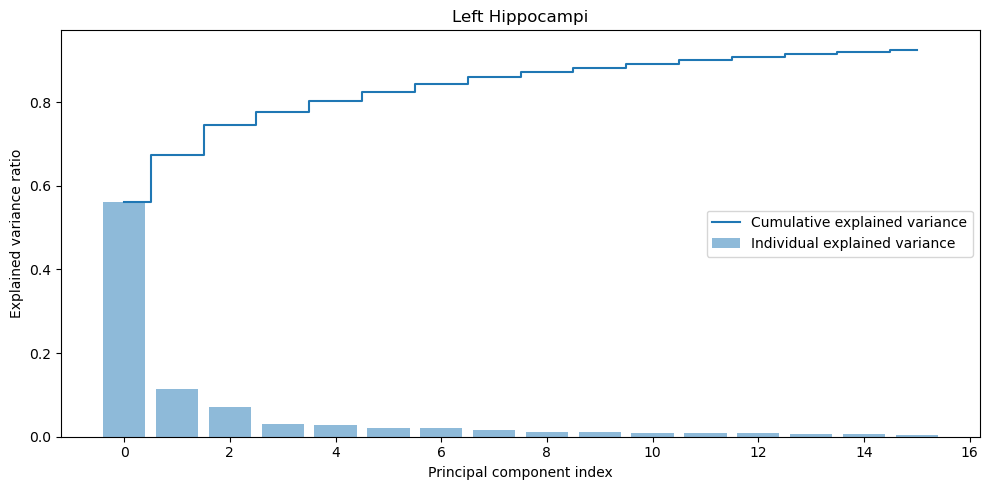

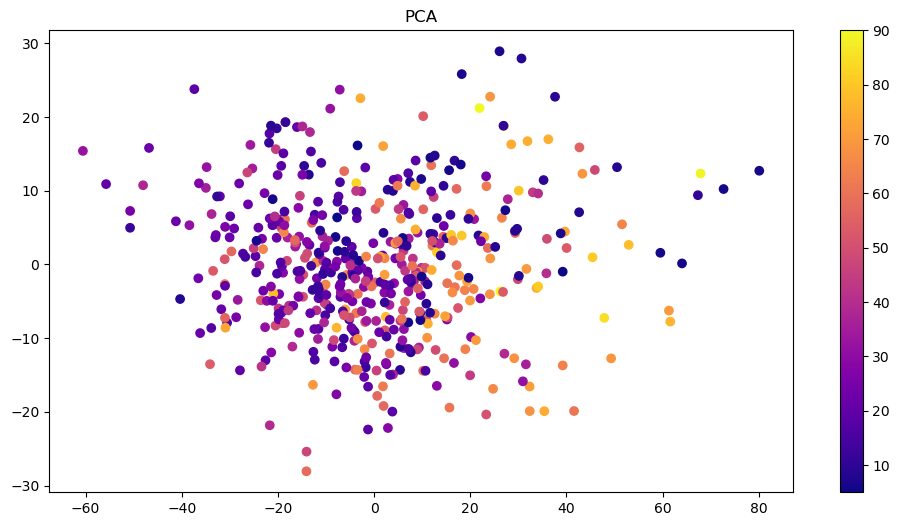

In [120]:
pca = PCA(n_components=16)
pca.fit(particles_array)
pca_latent = pca.transform(particles_array)

exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.figure(figsize=(10,5))
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='center right')
plt.title("Left Hippocampi")
plt.tight_layout()
plt.savefig("figures/left_hippo.png")
plt.show()

plt.rcParams["figure.figsize"] = [12, 6]
f, ax = plt.subplots()
points = ax.scatter(pca_latent[:,0], pca_latent[:,1], c=df.age.tolist(), cmap="plasma")
f.colorbar(points)
plt.title("PCA")
plt.show()

## Left hippocampus LDA

C:\Users\Hannes\miniconda3\envs\shapeworks\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


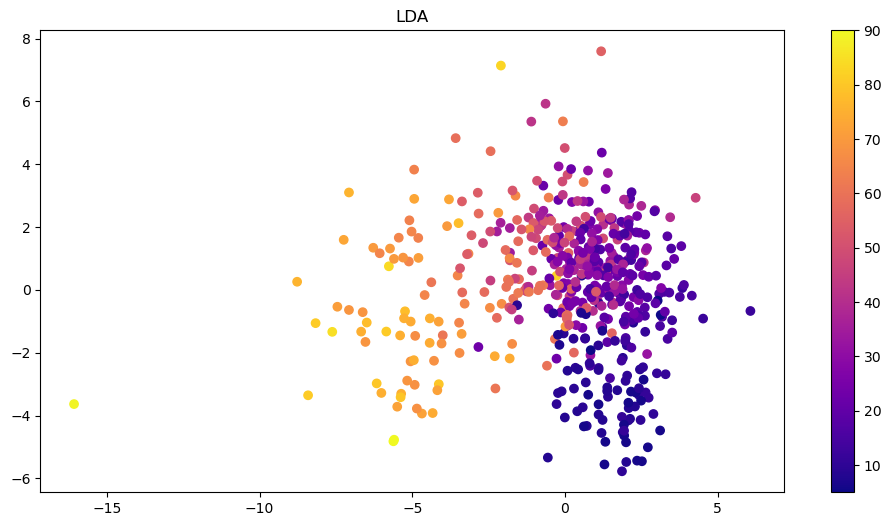

In [136]:
lda = LinearDiscriminantAnalysis(n_components=16)
lda.fit(particles_array, df.age.to_numpy().reshape(-1, 1))
lda_latent = lda.transform(particles_array)
#recon_particles = inverse_transform(lda, lda_latent)

plt.rcParams["figure.figsize"] = [12, 6]
f, ax = plt.subplots()
points = ax.scatter(lda_latent[:,0], lda_latent[:,1], c=df.age.tolist(), cmap="plasma")
f.colorbar(points)
plt.title("LDA")
plt.show()

## Left hippocampus Kernel PCA

In [42]:
# pca = KernelPCA(n_components=16, fit_inverse_transform=True)
# pca.fit(particles_array, df.age.to_numpy().reshape(-1, 1))
# pca_latent = pca.transform(particles_array)

# exp_var_pca = pca.explained_variance_ratio_
# cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# plt.figure(figsize=(10,5))
# plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
# plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
# plt.ylabel('Explained variance ratio')
# plt.xlabel('Principal component index')
# plt.legend(loc='center right')
# plt.title("Left Hippocampi")
# plt.tight_layout()
# plt.savefig("figures/left_hippo.png")
# plt.show()

## Right hippocampus PCA

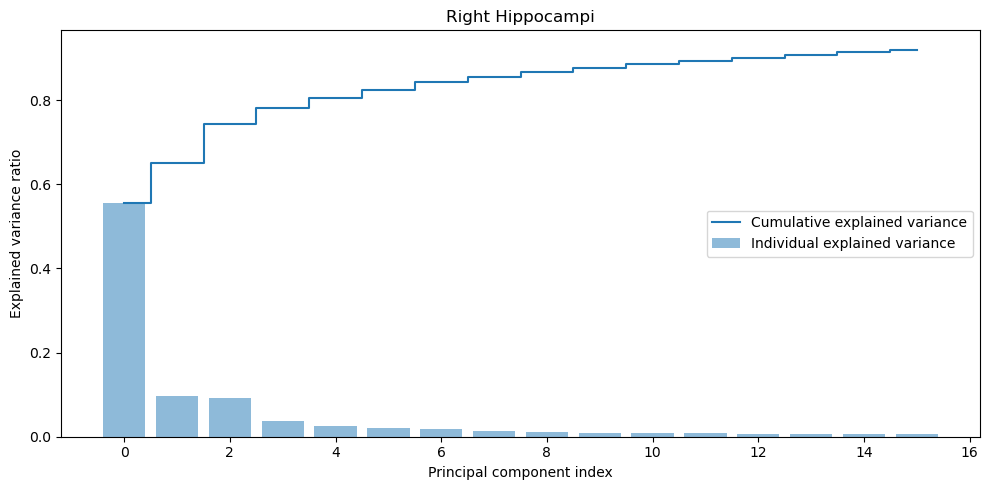

In [118]:
right_pca = PCA(n_components=16)
right_pca.fit(right_particles_array)
right_pca_latent = right_pca.transform(right_particles_array)

right_exp_var_pca = right_pca.explained_variance_ratio_
right_cum_sum_eigenvalues = np.cumsum(right_exp_var_pca)

plt.figure(figsize=(10,5))
plt.bar(range(0,len(right_exp_var_pca)), right_exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(right_cum_sum_eigenvalues)), right_cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='center right')
plt.title("Right Hippocampi")
plt.tight_layout()
plt.savefig("figures/right_hippo.png")
plt.show()

## Right hippocampus LDA

In [137]:
right_lda = LinearDiscriminantAnalysis(n_components=16)
right_lda.fit(right_particles_array, df.age.to_numpy().reshape(-1, 1))
right_lda_latent = right_lda.transform(right_particles_array)
#recon_particles = inverse_transform(lda, lda_latent)

C:\Users\Hannes\miniconda3\envs\shapeworks\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Right hippocampus Kernel PCA

In [44]:
# right_pca = KernelPCA(n_components=16, fit_inverse_transform=True)
# right_pca.fit(right_particles_array,  df.age.to_numpy().reshape(-1, 1))
# right_pca_latent = right_pca.transform(right_particles_array)

# right_exp_var_pca = right_pca.explained_variance_ratio_
# right_cum_sum_eigenvalues = np.cumsum(right_exp_var_pca)

# plt.figure(figsize=(10,5))
# plt.bar(range(0,len(right_exp_var_pca)), right_exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
# plt.step(range(0,len(right_cum_sum_eigenvalues)), right_cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
# plt.ylabel('Explained variance ratio')
# plt.xlabel('Principal component index')
# plt.legend(loc='center right')
# plt.title("Right Hippocampi")
# plt.tight_layout()
# plt.savefig("figures/right_hippo.png")
# plt.show()

## Latent traversal

In [138]:
maps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis']
shading = {"colormap": maps[2]}

In [152]:
hippo_shape = 5

#left
original_mesh = mesh_list[hippo_shape]
particles = sorted(glob(f"shape_model_{num_particles}/hippocampus_particles/*left_local.particles"))
original_particles = sw.ParticleSystem([particles[hippo_shape]]).ShapeAsPointSet(0)

#right
right_original_mesh = right_mesh_list[hippo_shape]
right_particles = sorted(glob(f"shape_model_{num_particles}/hippocampus_particles/*right_local.particles"))
right_original_particles = sw.ParticleSystem([right_particles[hippo_shape]]).ShapeAsPointSet(0)

#left
warper = sw.MeshWarper()
warper.generateWarp(original_mesh, original_particles)
warped_mesh = warper.buildMesh(original_particles)

#right
right_warper = sw.MeshWarper()
right_warper.generateWarp(right_original_mesh, right_original_particles)
right_warped_mesh = right_warper.buildMesh(right_original_particles)

p = mp.plot(warped_mesh.points(), warped_mesh.faces(), shading=shading)
p.add_mesh(right_warped_mesh.points(), right_warped_mesh.faces(), shading=shading)

pca_latent = lda_latent
right_pca_latent = right_lda_latent

std_0 = pca_latent[:,0].std()*100
std_1 = pca_latent[:,1].std()*100
std_2 = pca_latent[:,2].std()*100
std_3 = pca_latent[:,3].std()*100

@interact(z0=widgets.FloatSlider(value=pca_latent[hippo_shape][0], min=-2.5*std_0, max=2.5*std_0, step=0.01),
          z1=widgets.FloatSlider(value=pca_latent[hippo_shape][1], min=-2.5*std_1, max=2.5*std_1, step=0.01),
          z2=widgets.FloatSlider(value=pca_latent[hippo_shape][2], min=-2.5*std_2, max=2.5*std_2, step=0.01),
          z3=widgets.FloatSlider(value=pca_latent[hippo_shape][3], min=-2.5*std_3, max=2.5*std_3, step=0.01))
def visualize(z0, z1, z2, z3):
    latent_code = pca_latent[hippo_shape]
    right_latent_code = right_pca_latent[hippo_shape]
    
    #left
    latent_code[0] = z0
    latent_code[1] = z1
    latent_code[2] = z2
    latent_code[3] = z3
    
    #right
    right_latent_code[0] = z0
    right_latent_code[1] = z1
    right_latent_code[2] = z2
    right_latent_code[3] = z3
    
    #left mesh warp
    #recon_particles = pca.inverse_transform(latent_code.reshape(1,-1)).reshape(-1,3)
    recon_particles = inverse_transform(lda, latent_code.reshape(1,-1)).reshape(-1,3)
    recon_mesh = warper.buildMesh(recon_particles)
    
    #right mesh warp
    #right_recon_particles = right_pca.inverse_transform(right_latent_code.reshape(1,-1)).reshape(-1,3)
    right_recon_particles = inverse_transform(right_lda, right_latent_code.reshape(1,-1)).reshape(-1,3)
    right_recon_mesh = right_warper.buildMesh(right_recon_particles)
    
    #left distance
    diff = warped_mesh.points() - recon_mesh.points()
    dist = np.linalg.norm(diff, axis=1)
    
    #right distance
    right_diff = right_warped_mesh.points() - right_recon_mesh.points()
    right_dist = np.linalg.norm(right_diff, axis=1)
    
    mesh = trimesh.Trimesh(recon_mesh.points(), warped_mesh.faces())
    print(f"Volume: {mesh.volume:.2f}")
    
    #left
    p.update_object(oid=0, vertices=recon_mesh.points(), colors=dist)
    
    #right
    p.update_object(oid=1, vertices=right_recon_mesh.points(), colors=right_dist)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(88.343120…

interactive(children=(FloatSlider(value=10.695706931756035, description='z0', max=668.512451434604, min=-668.5…

## Left hippocampus SAP & Correlation

In [144]:
factors = df.age.to_numpy().reshape(-1,1)
codes = pca_latent
print(f"SAP score: {sap(factors, codes):.4f}")
correlation_list = []
for i in range(pca_latent.shape[1]):
    correlation_list.append(pearsonr(factors.reshape(-1), codes[:,i])[0])
    print(f"Correlation of age and latent code {i}: {correlation_list[i]:.4f}")

correlations = abs(np.array(correlation_list))
print(f"Max Correlation: {np.max(correlations):.4f}")

SAP score: 0.5780
Correlation of age and latent code 0: -0.7964
Correlation of age and latent code 1: 0.2373
Correlation of age and latent code 2: 0.0836
Correlation of age and latent code 3: 0.1697
Correlation of age and latent code 4: -0.0350
Correlation of age and latent code 5: 0.0143
Correlation of age and latent code 6: -0.0621
Correlation of age and latent code 7: 0.0074
Correlation of age and latent code 8: 0.0965
Correlation of age and latent code 9: -0.0039
Correlation of age and latent code 10: 0.0618
Correlation of age and latent code 11: -0.0146
Correlation of age and latent code 12: 0.0445
Correlation of age and latent code 13: 0.0712
Correlation of age and latent code 14: -0.0660
Correlation of age and latent code 15: 0.0876
Max Correlation: 0.7964


## Right hippocampus SAP & Correlation

In [145]:
factors = df.age.to_numpy().reshape(-1,1)
right_codes = right_pca_latent
print(f"SAP score: {sap(factors, right_codes):.4f}")
correlation_list = []
for i in range(pca_latent.shape[1]):
    correlation_list.append(pearsonr(factors.reshape(-1), right_codes[:,i])[0])
    print(f"Correlation of age and latent code {i}: {correlation_list[i]:.4f}")

correlations = abs(np.array(correlation_list))
print(f"Max Correlation: {np.max(correlations):.4f}")

SAP score: 0.6119
Correlation of age and latent code 0: 0.7873
Correlation of age and latent code 1: -0.0615
Correlation of age and latent code 2: -0.0105
Correlation of age and latent code 3: 0.0063
Correlation of age and latent code 4: 0.0660
Correlation of age and latent code 5: 0.0016
Correlation of age and latent code 6: 0.0254
Correlation of age and latent code 7: 0.0614
Correlation of age and latent code 8: 0.0463
Correlation of age and latent code 9: 0.0885
Correlation of age and latent code 10: -0.0203
Correlation of age and latent code 11: 0.0672
Correlation of age and latent code 12: 0.0170
Correlation of age and latent code 13: -0.0893
Correlation of age and latent code 14: 0.0087
Correlation of age and latent code 15: -0.0430
Max Correlation: 0.7873


## Summary plot: SAP score over Reconstruction error

In [61]:
mean_dist_left_128 = 1.9119
mean_dist_right_128 = 1.8809
mean_dist_overall_128 = 3.7928
mean_dist_left_256 = 1.4925
mean_dist_right_256 = 1.4968
mean_dist_overall_256 = 2.9894
mean_dist_left_512 = 1.4250
mean_dist_right_512 = 1.4364
mean_dist_overall_512 = 2.8615
mean_dist_left_1024 = 1.4178
mean_dist_right_1024 = 1.6426
mean_dist_overall_1024 = 3.0605
mean_dist_left_2048 = 1.5290
mean_dist_right_2048 = 1.4979
mean_dist_overall_2048 = 3.0269

sap_score_left_128 = 0.0936
sap_score_right_128 = 0.1176
sap_score_left_256 = 0.0931
sap_score_right_256 = 0.1146
sap_score_left_512 = 0.0975
sap_score_right_512 = 0.1156
sap_score_left_1024 = 0.1207
sap_score_right_1024 = 0.1088
sap_score_left_2048 = 0.1329
sap_score_right_2048 = 0.1053

corr_left_128 = 0.2490
corr_right_128 = 0.3894
corr_left_256 = 0.2215
corr_right_256 = 0.2092
corr_left_512 = 0.2516
corr_right_512 = 0.2612
corr_left_1024 = 0.2774
corr_right_1024 = 0.2904
corr_left_2048 = 0.2956
corr_right_2048 = 0.2215

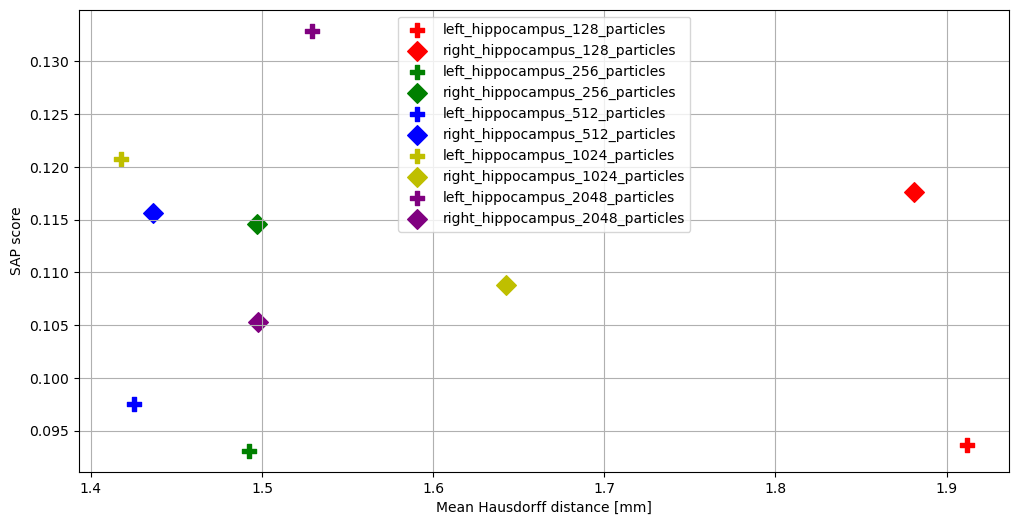

In [17]:
plt.figure(figsize=(12,6))

markersize = 100

plt.scatter(mean_dist_left_128, sap_score_left_128, markersize, marker="P", c="r", label="left_hippocampus_128_particles")
plt.scatter(mean_dist_right_128, sap_score_right_128, markersize, marker="D", c="r", label="right_hippocampus_128_particles")
plt.scatter(mean_dist_left_256, sap_score_left_256, markersize, marker="P", c="g", label="left_hippocampus_256_particles")
plt.scatter(mean_dist_right_256, sap_score_right_256, markersize, marker="D", c="g", label="right_hippocampus_256_particles")
plt.scatter(mean_dist_left_512, sap_score_left_512, markersize, marker="P", c="b", label="left_hippocampus_512_particles")
plt.scatter(mean_dist_right_512, sap_score_right_512, markersize, marker="D", c="b", label="right_hippocampus_512_particles")
plt.scatter(mean_dist_left_1024, sap_score_left_1024, markersize, marker="P", c="y", label="left_hippocampus_1024_particles")
plt.scatter(mean_dist_right_1024, sap_score_right_1024, markersize, marker="D", c="y", label="right_hippocampus_1024_particles")
plt.scatter(mean_dist_left_2048, sap_score_left_2048, markersize, marker="P", c="purple", label="left_hippocampus_2048_particles")
plt.scatter(mean_dist_right_2048, sap_score_right_2048, markersize, marker="D", c="purple", label="right_hippocampus_2048_particles")


plt.xlabel("Mean Hausdorff distance [mm]")
plt.ylabel("SAP score")

plt.legend()
plt.grid(True)
plt.show()

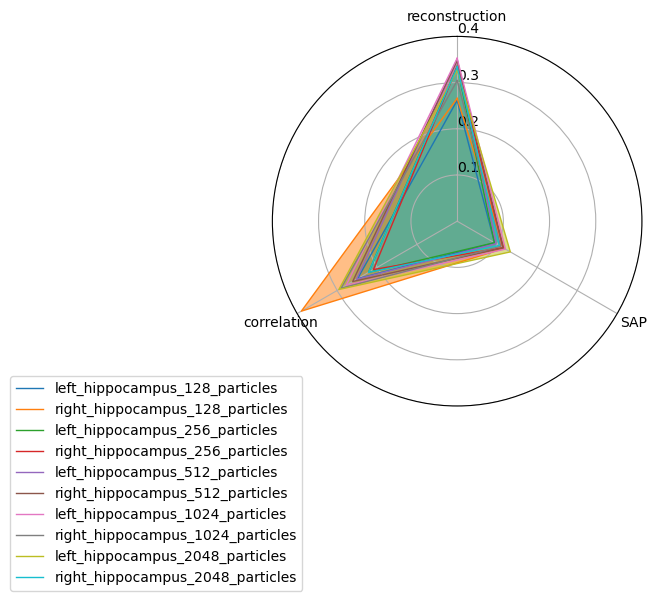

In [110]:
from math import pi

recon_scale_factor = 2

# Set data
df = pd.DataFrame({
'group': ['left_hippocampus_128_particles','right_hippocampus_128_particles',
          'left_hippocampus_256_particles','right_hippocampus_256_particles',
          'left_hippocampus_512_particles','right_hippocampus_512_particles',
          'left_hippocampus_1024_particles','right_hippocampus_1024_particles',
          'left_hippocampus_2048_particles','right_hippocampus_2048_particles',],
'reconstruction': [1/(mean_dist_left_128*recon_scale_factor), 1/(mean_dist_right_128*recon_scale_factor), 
                   1/(mean_dist_left_256*recon_scale_factor), 1/(mean_dist_right_256*recon_scale_factor),
                   1/(mean_dist_left_512*recon_scale_factor), 1/(mean_dist_right_512*recon_scale_factor),
                   1/(mean_dist_left_1024*recon_scale_factor), 1/(mean_dist_right_1024*recon_scale_factor),
                   1/(mean_dist_left_2048*recon_scale_factor), 1/(mean_dist_right_2048*recon_scale_factor)],
    
'SAP': [sap_score_left_128, sap_score_right_128,
        sap_score_left_256, sap_score_right_256,
        sap_score_left_512, sap_score_right_512,
        sap_score_left_1024, sap_score_right_1024,
        sap_score_left_2048, sap_score_right_2048],
    
'correlation': [corr_left_128, corr_right_128,
                corr_left_256, corr_right_256,
                corr_left_512, corr_right_512,
                corr_left_1024, corr_right_1024,
                corr_left_2048, corr_right_2048]
})
 
# ------- PART 1: Create background
 
# number of variable
categories=list(df)[1:]
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0.1,0.2,0.3,0.4], ["0.1","0.2","0.3","0.4"], color="black", size=10)
plt.ylim(0,0.4)
 

# ------- PART 2: Add plots

for i in range(len(df.group)):
    values=df.loc[i].drop('group').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=df.group.to_list()[i])
    ax.fill(angles, values, alpha=0.5)

# # Ind1
# values=df.loc[0].drop('group').values.flatten().tolist()
# values += values[:1]
# ax.plot(angles, values, linewidth=1, linestyle='solid', label="group A")
# ax.fill(angles, values, 'b', alpha=0.1)
 
# # Ind2
# values=df.loc[1].drop('group').values.flatten().tolist()
# values += values[:1]
# ax.plot(angles, values, linewidth=1, linestyle='solid', label="group B")
# ax.fill(angles, values, 'r', alpha=0.1
 
# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# Show the graph
plt.show()
